训练集大小: 797, 测试集大小: 342
测试集中高二元变量分布: (342, 43) (342, 1)
Counter({0: 236, 1: 106})
训练集中高二元变量分布: (797, 43) (797, 1)
Counter({0: 567, 1: 230})
开始训练LightGBM模型。。。


C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 230, number of negative: 567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 797, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288582 -> initscore=-0.902280
[LightGBM] [Info] Start training from score -0.902280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

C:\Users\29688\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


<Figure size 800x600 with 0 Axes>

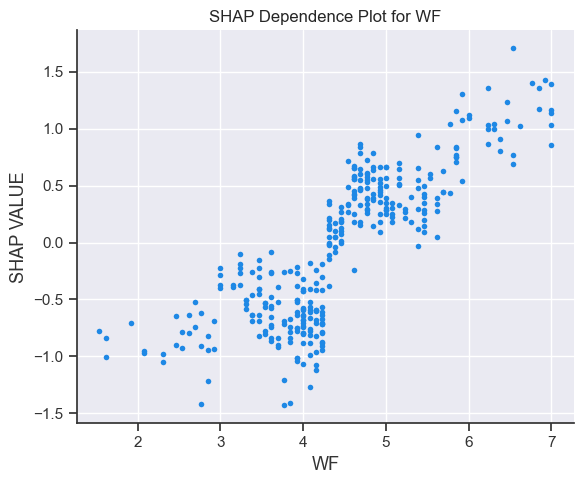

<Figure size 800x600 with 0 Axes>

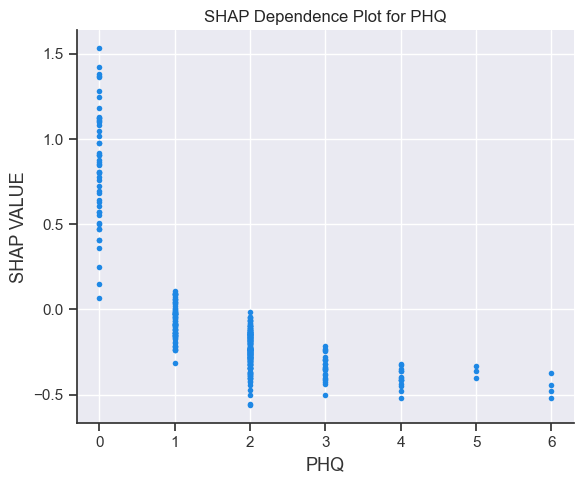

<Figure size 800x600 with 0 Axes>

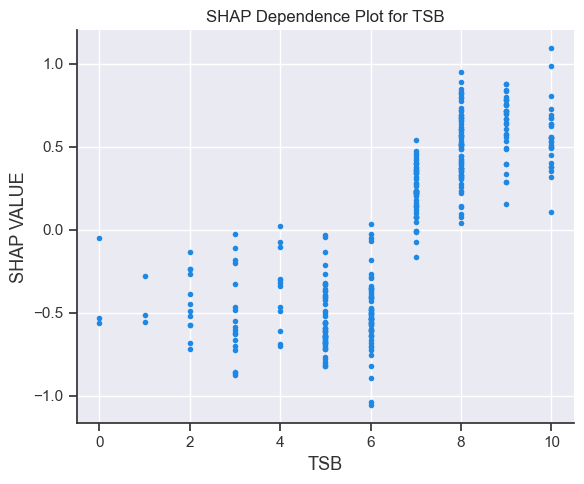

<Figure size 800x600 with 0 Axes>

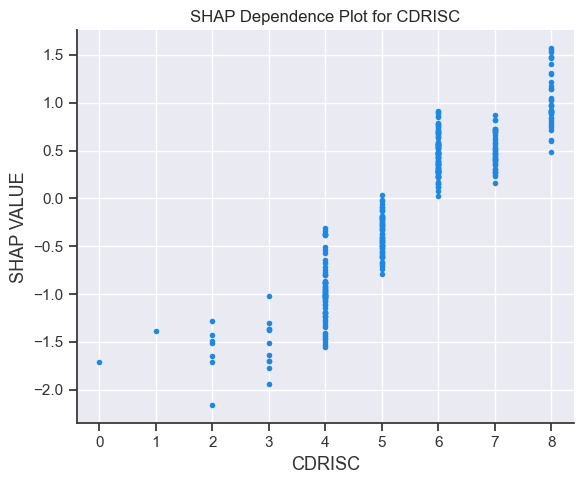

<Figure size 800x600 with 0 Axes>

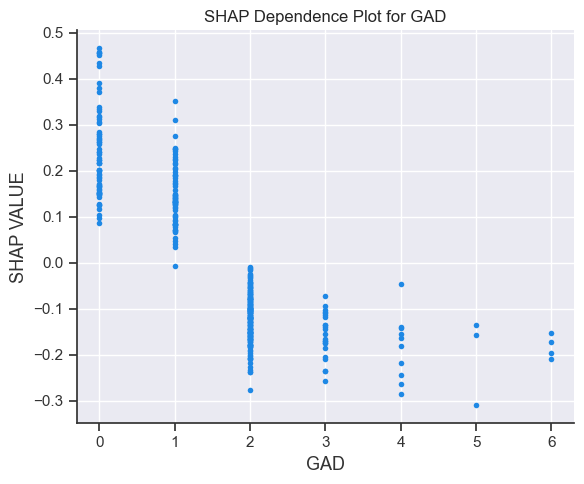

<Figure size 800x600 with 0 Axes>

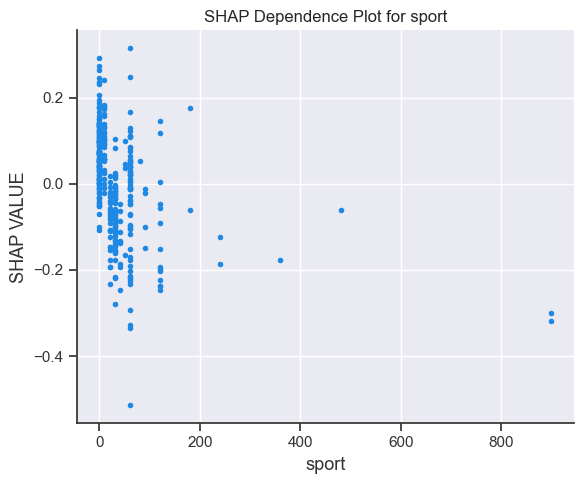

<Figure size 800x600 with 0 Axes>

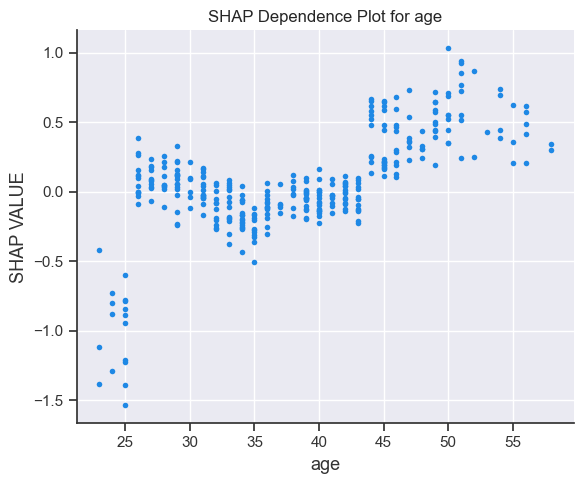

<Figure size 800x600 with 0 Axes>

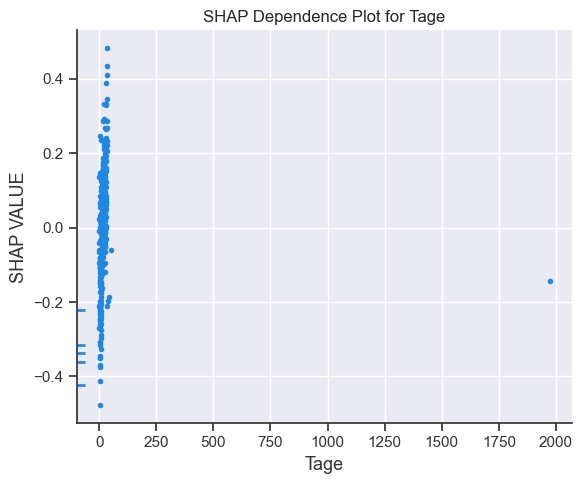

<Figure size 800x600 with 0 Axes>

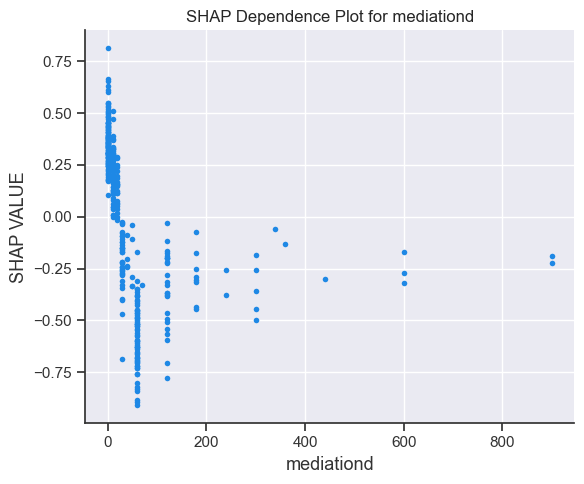

<Figure size 800x600 with 0 Axes>

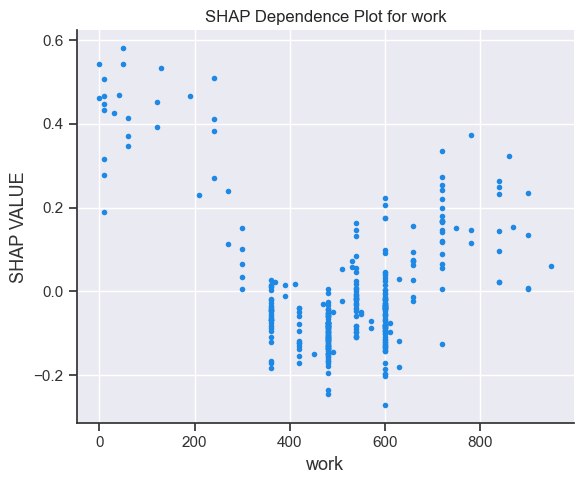

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\29688\\Desktop\\study_4\\pictures\\middle\\shap_summary_plot.png'

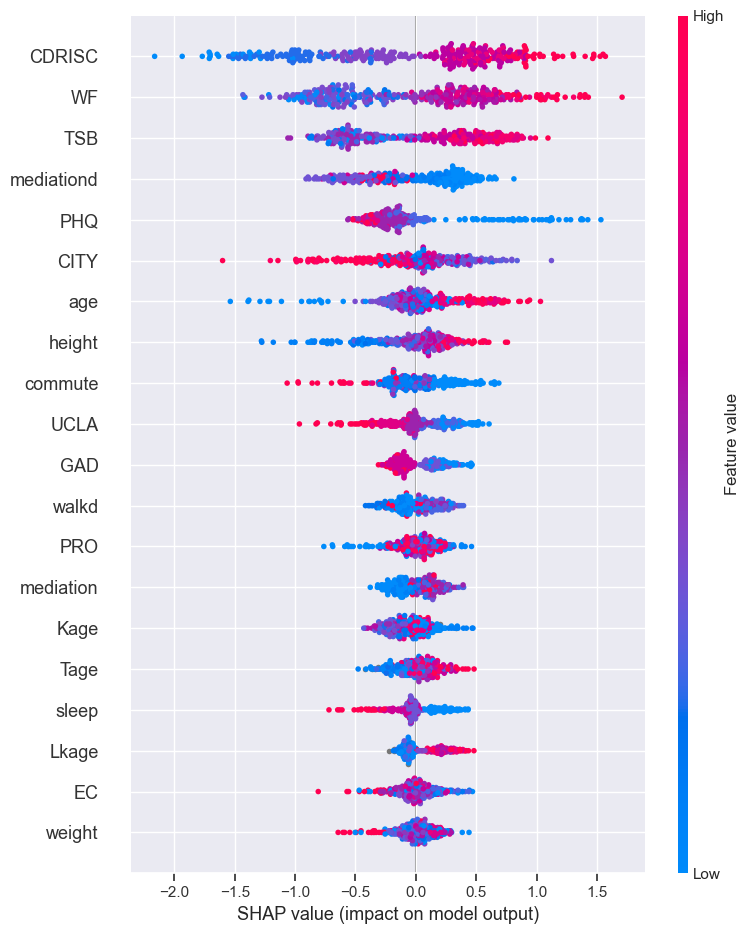

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import seaborn as sns

def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1score:.4f}")
    return accuracy, precision, recall, f1score

def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

def get_feature_importance(model, x_test, y_test, top_n):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    feature_importances = model.feature_importances_
    feature_names = np.array(list(x_test.columns))
    top_features = feature_names[perm_sorted_idx][-top_n:][::-1]
    top_indices = perm_sorted_idx[-top_n:][::-1]
    return feature_importances, perm_sorted_idx, shap_values, top_features, top_indices

def machine_learning(df_src, df_tgt, top_n, split_ratio=0.3, random_seed=28):
    xstd = df_src.std()
    xmean = df_src.mean()
    x_normalized = (df_src - xmean) / xstd

    x_train, x_test, y_train, y_test = train_test_split(x_normalized, df_tgt, test_size=split_ratio,
                                                        random_state=random_seed, shuffle=True)

    xtestvalue = x_test * xstd + xmean

    print(f"训练集大小: {len(x_train)}, 测试集大小: {len(x_test)}")
    print('测试集中高二元变量分布:', x_test.shape, y_test.shape)
    print(Counter(y_test['middle_binary']))
    print('训练集中高二元变量分布:', x_train.shape, y_train.shape)
    print(Counter(y_train['middle_binary']))

    result_map = {}

    print("开始训练LightGBM模型。。。")
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)

    dt_feature_importance, permsortedidx, shapevalues, top_features, top_indices = get_feature_importance(gbm, x_test, y_test, top_n)
    print('特征重要性:')
    print(dt_feature_importance)
    print('排列索引:')
    print(permsortedidx)
    print('SHAP值:')
    print(shapevalues)
    print('前十重要特征:')
    print(top_features)
    print('前十重要特征索引:')
    print(top_indices)

    result_map['LightGBM'] = (
    top_features, top_indices, xstd, xmean, xtestvalue, shapevalues, x_test, y_test, gbm.predict_proba(x_test)[:, 1])

    calc_metrics(y_test, y_predict_test)

    return result_map

def plot_shap_dependence(model_name, xtest_value, shap_values, top_features, df_src, save_folder):
    boundaries = {feature_name: [1.5, 2.5, 3.5] for feature_name in top_features}
    print('将下面的输出复制到箱线图的boundaries处，并根据依赖图的横坐标去修改后面的分组区间，start为上限0, stop为下限10, num为个数6。')
    print("boundaries_x = {")
    for feature_name, values in boundaries.items():
        print(f"    '{feature_name}': np.linspace(start:0, stop:10, num:6),")
    print("}")

    for feature_name in top_features:
        feature_index = np.where(df_src.columns == feature_name)[0][0]
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature_index, xtest_value, shap_values, interaction_index=None, show=False)

        # 设置图像标题和保存路径
        plt.title(f'SHAP Dependence Plot for {feature_name}')
        file_name = f'{feature_name}_shap_dependence.png'
        save_path = os.path.join(save_folder, file_name)
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.tight_layout()
        plt.show()

# 导入数据
df_path = r"C:\Users\29688\Desktop\幸福教师\T1_T2.xlsx"
save_folder = r"C:\Users\29688\Desktop\study_4\pictures\middle"  # 替换为你的保存路径
top_n = 10

df = pd.read_excel(df_path)

# 自变量
df_src = df[['PRO', 'CITY', 'gender', 'age', 'minzu','height','weight', 'kid', 'Bkage',
             'Lkage', 'Kage', 'education', 'xueduan','BZR', 'grade',
             'title', 'Tage', 'PHQ', 'GAD', 'UCLA', 'CDRISC', 'sleep', 'rise', 'sleep_duration',
             'sleep_min', 'sleepd', 'rised', 'sleepd_hours', 'sleepd_min', 'commute', 'work','mediation','mediationd',
             'sport','walk','sportd','walkd','TE','subject','SE','TSB','EC','WF']].astype(float)
# 因变量
df_tgt = df[['middle_binary']]

# 运行机器学习并获取结果
result_map = machine_learning(df_src, df_tgt, top_n)

for model_name, vals in result_map.items():
    top_features = vals[0]  # 获取前十重要特征
    xtest_value = vals[-4]
    shap_values = vals[-5]
    sns.set_theme(style="darkgrid")

    plot_shap_dependence(model_name, xtest_value, shap_values, top_features, df_src, save_folder)
    
    # 保存SHAP summary plot
    shap.summary_plot(vals[-4], vals[-5], show=False)  # 禁用自动显示
    plt.tight_layout()  # 确保布局完整
    file_name = 'shap_summary_plot.png'
    save_path = os.path.join(save_folder, file_name)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)  # 保存图像
    plt.show()  # 显示图像

训练集大小: 797, 测试集大小: 342
测试集中高二元变量分布: (342, 43) (342, 1)
Counter({0: 236, 1: 106})
训练集中高二元变量分布: (797, 43) (797, 1)
Counter({0: 567, 1: 230})
开始训练LightGBM模型。。。
[LightGBM] [Info] Number of positive: 230, number of negative: 567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 797, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288582 -> initscore=-0.902280
[LightGBM] [Info] Start training from score -0.902280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\29688\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


特征重要性:
[128 137   3 120   7 147 156   7  79  73  79  22  33   4  54  41 139  53
  48  70  95  42  25  33   0  25  46  33   0 101  90  76  89  87  54  58
  79  78  82  54 100 124 193]
排列索引:
[10  1 26 36  5 35 19 27 21 34 39 32 37 22 23  6  9 12  8  0 30 33 41 15
 14 29 38  2  7 25 31 24 28 13 16  4 18 11  3 20 40 17 42]
SHAP值:
[[ 0.2033948  -0.38335032 -0.01268711 ...  0.07521245  0.21823515
  -0.95768096]
 [ 0.13159959  0.79528417 -0.00506697 ...  0.41808332 -0.05624059
   0.10436582]
 [ 0.09034202  0.4131821  -0.00394847 ...  0.424914   -0.02294482
  -0.52222244]
 ...
 [ 0.15083618 -0.39768537  0.00951766 ... -0.23521302  0.03483045
  -0.57956556]
 [ 0.09718555  0.27923389 -0.00175139 ... -0.32372609 -0.04994926
   0.57884976]
 [ 0.15181738 -0.10651599 -0.01167442 ...  0.75079746 -0.10444508
  -0.70959699]]
前十重要特征:
['WF' 'PHQ' 'TSB' 'CDRISC' 'age' 'education' 'GAD' 'minzu' 'Tage' 'BZR']
前十重要特征索引:
[42 17 40 20  3 11 18  4 16 13]
Accuracy: 0.7251, Precision: 0.6071, Recall: 0.3208, F1-s

C:\Users\29688\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\29688\\Desktop\\study_4\\pictures\\middle\\PRO_shap_dependence.png'

<Figure size 800x600 with 0 Axes>

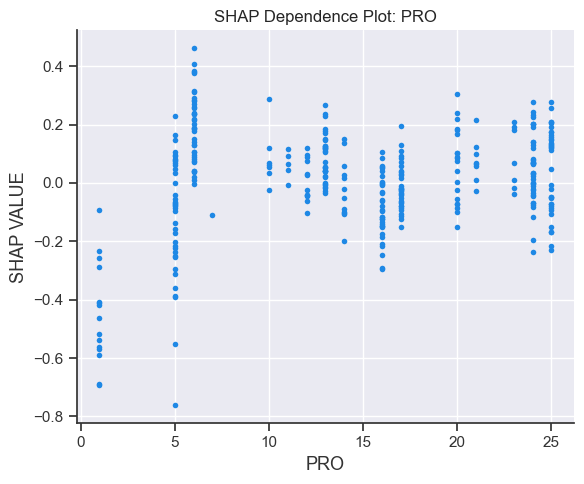

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import seaborn as sns

def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1score:.4f}")
    return accuracy, precision, recall, f1score

def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

def get_feature_importance(model, x_test, y_test, top_n):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    feature_importances = model.feature_importances_
    feature_names = np.array(list(x_test.columns))
    top_features = feature_names[perm_sorted_idx][-top_n:][::-1]
    top_indices = perm_sorted_idx[-top_n:][::-1]
    return feature_importances, perm_sorted_idx, shap_values, top_features, top_indices

def machine_learning(df_src, df_tgt, top_n, split_ratio=0.3, random_seed=28):
    xstd = df_src.std()
    xmean = df_src.mean()
    x_normalized = (df_src - xmean) / xstd

    x_train, x_test, y_train, y_test = train_test_split(x_normalized, df_tgt, test_size=split_ratio,
                                                        random_state=random_seed, shuffle=True)

    xtestvalue = x_test * xstd + xmean

    print(f"训练集大小: {len(x_train)}, 测试集大小: {len(x_test)}")
    print('测试集中高二元变量分布:', x_test.shape, y_test.shape)
    print(Counter(y_test['middle_binary']))
    print('训练集中高二元变量分布:', x_train.shape, y_train.shape)
    print(Counter(y_train['middle_binary']))

    result_map = {}

    print("开始训练LightGBM模型。。。")
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)

    dt_feature_importance, permsortedidx, shapevalues, top_features, top_indices = get_feature_importance(gbm, x_test, y_test, top_n)
    print('特征重要性:')
    print(dt_feature_importance)
    print('排列索引:')
    print(permsortedidx)
    print('SHAP值:')
    print(shapevalues)
    print('前十重要特征:')
    print(top_features)
    print('前十重要特征索引:')
    print(top_indices)

    result_map['LightGBM'] = (
    top_features, top_indices, xstd, xmean, xtestvalue, shapevalues, x_test, y_test, gbm.predict_proba(x_test)[:, 1])

    calc_metrics(y_test, y_predict_test)

    return result_map

def plot_shap_dependence(model_name, xtest_value, shap_values, all_features, df_src, save_folder):
    # 遍历每个特征生成SHAP依赖图
    for feature_name in all_features:
        feature_index = np.where(df_src.columns == feature_name)[0][0]  # 获取特征的索引
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature_index, xtest_value, shap_values, interaction_index=None, show=False)

        # 设置图像标题和保存路径
        plt.title(f'SHAP Dependence Plot: {feature_name}')
        file_name = f'{feature_name}_shap_dependence.png'
        save_path = os.path.join(save_folder, file_name)
        plt.xlabel(feature_name)
        plt.ylabel('SHAP VALUE')
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()

# 导入数据
df_path = r"C:\Users\29688\Desktop\幸福教师\T1_T2.xlsx"
save_folder = r"C:\Users\29688\Desktop\study_4\pictures\middle"  # 替换为你的保存路径
top_n = 10

df = pd.read_excel(df_path)

# 自变量
df_src = df[['PRO', 'CITY', 'gender', 'age', 'minzu','height','weight', 'kid', 'Bkage',
             'Lkage', 'Kage', 'education', 'xueduan','BZR', 'grade',
             'title', 'Tage', 'PHQ', 'GAD', 'UCLA', 'CDRISC', 'sleep', 'rise', 'sleep_duration',
             'sleep_min', 'sleepd', 'rised', 'sleepd_hours', 'sleepd_min', 'commute', 'work','mediation','mediationd',
             'sport','walk','sportd','walkd','TE','subject','SE','TSB','EC','WF']].astype(float)
# 因变量
df_tgt = df[['middle_binary']]

# 运行机器学习并获取结果
result_map = machine_learning(df_src, df_tgt, top_n)

for model_name, vals in result_map.items():
    shap_values = vals[-5]  # SHAP值
    xtest_value = vals[-4]  # 测试集的特征值
    sns.set_theme(style="darkgrid")

    # 遍历所有特征生成SHAP依赖图
    all_features = df_src.columns.tolist()  # 获取所有特征
    plot_shap_dependence(model_name, xtest_value, shap_values, all_features, df_src, save_folder)

    # 保存SHAP summary plot
    shap.summary_plot(xtest_value, shap_values)
    file_name = 'shap_summary_plot.png'
    save_path = os.path.join(save_folder, file_name)
    plt.show()
